In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import statsmodels.api as sms
from datetime import datetime 
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from prophet import Prophet
warnings.filterwarnings("ignore")
%matplotlib inline

Importing plotly failed. Interactive plots will not work.


In [2]:
df_train= pd.read_csv("train.csv")
df_fea= pd.read_csv("features.csv")
df_store= pd.read_csv("stores.csv")

In [3]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [4]:
# Manage 'Weekly_Sales' to be positive for convenience  
df_train= df_train[df_train['Weekly_Sales']>0]
df_train.describe()

,Store,Dept,Weekly_Sales
count,420212.000000,420212.000000,420212.000000
mean,22.195611,44.241309,16033.114591
std,12.787236,30.508819,22729.492116
min,1.000000,1.000000,0.010000
25%,11.000000,18.000000,2120.130000
50%,22.000000,37.000000,7661.700000
75%,33.000000,74.000000,20271.265000
max,45.000000,99.000000,693099.360000


In [5]:
df_store.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [6]:
df_fea.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [7]:
df_train_new = df_train.merge(df_fea, on=['Store','Date'], how = 'inner').merge(df_store,on=['Store'],
                                                                                how = 'inner')

In [8]:
df_train_new

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420207,45,93,2012-10-26,2487.80,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221
420208,45,94,2012-10-26,5203.31,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221
420209,45,95,2012-10-26,56017.47,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221
420210,45,97,2012-10-26,6817.48,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221


In [9]:
df_train_new = df_train_new.drop('IsHoliday_y',axis=1)

In [10]:
df_train_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420212 entries, 0 to 420211
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         420212 non-null  int64  
 1   Dept          420212 non-null  int64  
 2   Date          420212 non-null  object 
 3   Weekly_Sales  420212 non-null  float64
 4   IsHoliday_x   420212 non-null  bool   
 5   Temperature   420212 non-null  float64
 6   Fuel_Price    420212 non-null  float64
 7   MarkDown1     150181 non-null  float64
 8   MarkDown2     110904 non-null  float64
 9   MarkDown3     136651 non-null  float64
 10  MarkDown4     134518 non-null  float64
 11  MarkDown5     150929 non-null  float64
 12  CPI           420212 non-null  float64
 13  Unemployment  420212 non-null  float64
 14  Type          420212 non-null  object 
 15  Size          420212 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.7+ MB


In [11]:
df_train_new.rename(columns={'IsHoliday_x':'IsHoliday'}, inplace=True)

In [12]:
# Fill NA
df_train_new.fillna(0, inplace=True)
df_train_new.isna().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
dtype: int64

In [13]:
df_train_new['Date'] = pd.to_datetime(df_train_new['Date'], format='%Y-%m-%d')

In [14]:
df_train_new.set_index('Date', inplace=True)

In [15]:
df_train_new = df_train_new.resample('MS').mean()

In [16]:
df_train_new.rename(columns={'Weekly_Sales':'Monthly_Sales'}, inplace=True)

In [17]:
train_df = df_train_new[:int(0.8*(len(df_train_new)))]
test_df = df_train_new[int(0.8*(len(df_train_new))):]

In [18]:
train = train_df['Monthly_Sales']
test = test_df['Monthly_Sales']

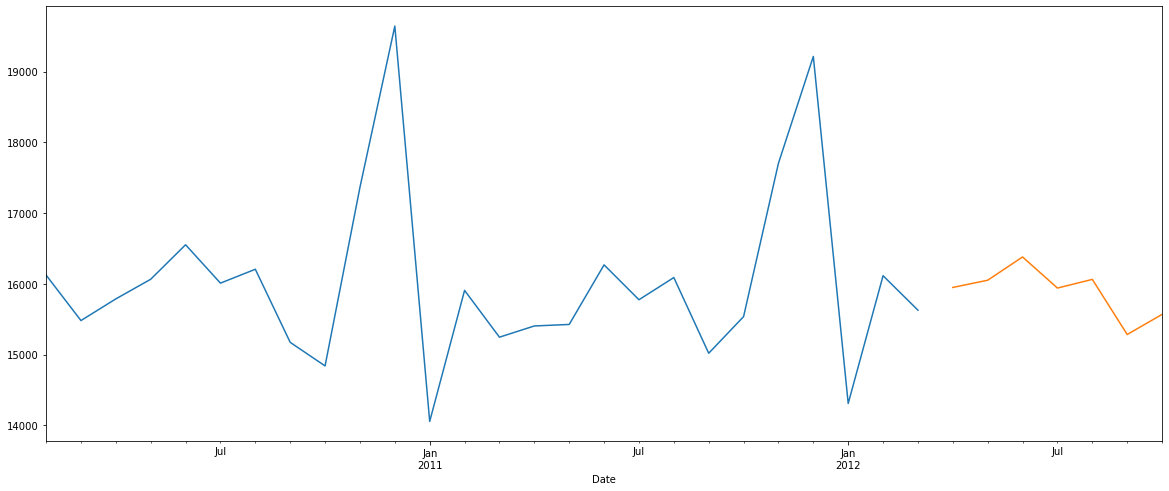

In [19]:
train.plot(figsize=(20,8))
test.plot(figsize=(20,8))
plt.show()

In [20]:
train.head()

Date
2010-02-01    16123.339183
2010-03-01    15480.222209
2010-04-01    15786.479121
2010-05-01    16063.976174
2010-06-01    16551.606753
Freq: MS, Name: Monthly_Sales, dtype: float64

In [21]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [22]:
adf_test(train)

ADF Statistics: -5.116882330046289
p- value: 1.2963600508552113e-05
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


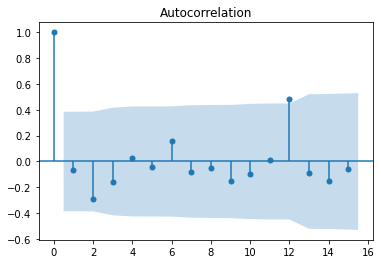

In [23]:
acf = plot_acf(train)

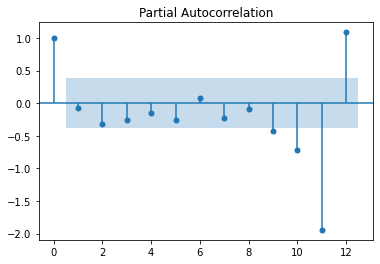

In [24]:
pacf = plot_pacf(train,lags=12)

In [25]:
train = train.to_frame()

In [26]:
train['Diff_1'] = train['Monthly_Sales'] - train['Monthly_Sales'].shift(1)

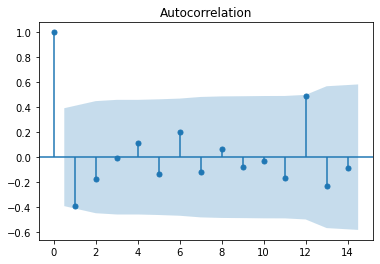

In [27]:
acf = plot_acf(train['Diff_1'].dropna())

In [28]:
train['Diff_1_12'] = train['Diff_1'] - train['Diff_1'].shift(12)

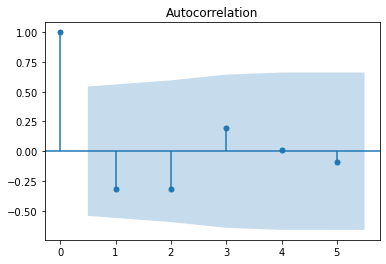

In [29]:
acf = plot_acf(train['Diff_1_12'].dropna(), lags=5)

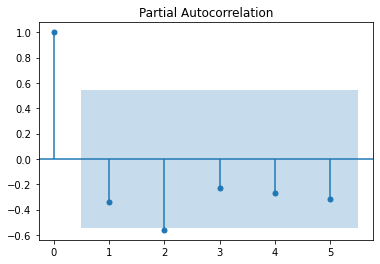

In [30]:
pacf = plot_pacf(train['Diff_1_12'].dropna(), lags=5)

In [31]:
model_auto_arima = auto_arima(train['Diff_1_12'], trace=True, suppress_warnings=True,start_p=0, start_q=0, 
                              start_P=0, start_Q=0, max_p=10, max_q=10, max_P=10, max_Q=10, seasonal=True,m=12,
                              stepwise=False, D=0,d=0, max_D=10,error_action='ignore',approximation = False)
model_auto_arima.fit(train['Diff_1_12'])

 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=197.085, Time=0.04 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(0,0,3)[12] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,0,0)(0,0,4)[12] intercept   : AIC=inf, Time=0.75 sec
 ARIMA(0,0,0)(0,0,5)[12] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,0,0)(1,0,3)[12] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(0,0,0)(1,0,4)[12] intercept   : AIC=inf, Time=1.03 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=197.399, Time=0.42 sec
 ARIMA(0,0,0)(2,0,3)[12] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(0,0,0)(3,0,0)[12] intercept   : AIC=inf, Time=0.62 sec


ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(2, 0, 1, 12),
      suppress_warnings=True)

In [32]:
train_df.corr()

,Store,Dept,Monthly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
Store,1.000000,0.068862,-0.021460,-0.252861,0.520117,0.617694,0.150628,0.046078,-0.054947,0.130868,0.102862,0.462577,-0.426161,-0.628257
Dept,0.068862,1.000000,0.395792,0.062612,0.059348,0.233741,0.506374,0.551308,0.256707,0.451358,0.681702,0.480208,-0.484477,-0.295009
Monthly_Sales,-0.021460,0.395792,1.000000,0.466462,-0.160242,-0.107343,0.092370,0.181661,0.307826,0.054307,0.340639,0.019784,0.036347,-0.096781
IsHoliday,-0.252861,0.062612,0.466462,1.000000,-0.412480,-0.166582,0.295296,0.211659,0.326306,0.292968,0.323043,0.082123,-0.049803,0.000852
Temperature,0.520117,0.059348,-0.160242,-0.412480,1.000000,0.086489,-0.308252,-0.405353,-0.120904,-0.256619,-0.405031,-0.142535,0.173824,0.068990
Fuel_Price,0.617694,0.233741,-0.107343,-0.166582,0.086489,1.000000,0.287396,0.158601,0.119349,0.232890,0.250599,0.792641,-0.705852,-0.692310
MarkDown1,0.150628,0.506374,0.092370,0.295296,-0.308252,0.287396,1.000000,0.532100,0.178631,0.969332,0.765611,0.632488,-0.690663,-0.474152
MarkDown2,0.046078,0.551308,0.181661,0.211659,-0.405353,0.158601,0.532100,1.000000,0.178988,0.426163,0.869407,0.606782,-0.656769,-0.538214
MarkDown3,-0.054947,0.256707,0.307826,0.326306,-0.120904,0.119349,0.178631,0.178988,1.000000,0.037618,0.280209,0.266060,-0.254675,-0.173988
MarkDown4,0.130868,0.451358,0.054307,0.292968,-0.256619,0.232890,0.969332,0.426163,0.037618,1.000000,0.655702,0.512205,-0.568134,-0.354935


<AxesSubplot:>

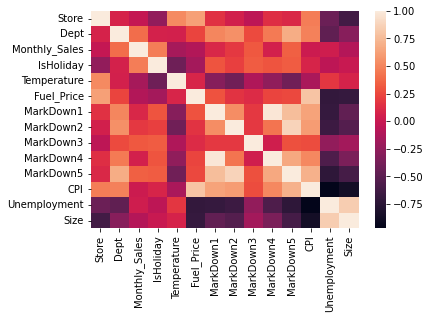

In [33]:
sns.heatmap(train_df.corr())

In [34]:
train = train['Monthly_Sales']

In [35]:
model_SARIMA = SARIMAX(train,order=(1,1,0),seasonal_order=(2,1,1,12))
model_SARIMA_fit = model_SARIMA.fit()
model_SARIMA_fit.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71903D+00    |proj g|=  2.02892D-01

At iterate    5    f=  3.67527D+00    |proj g|=  6.57815D-03

At iterate   10    f=  3.67510D+00    |proj g|=  5.76812D-03

At iterate   15    f=  3.67500D+00    |proj g|=  2.93109D-04

At iterate   20    f=  3.67498D+00    |proj g|=  2.72244D-03

At iterate   25    f=  3.67357D+00    |proj g|=  1.58811D-02

At iterate   30    f=  3.66247D+00    |proj g|=  2.90945D-02

At iterate   35    f=  3.64577D+00    |proj g|=  2.44557D-02

At iterate   40    f=  3.64243D+00    |proj g|=  1.91238D-02

At iterate   45    f=  3.64079D+00    |proj g|=  2.27027D-03

At iterate   50    f=  3.64017D+00    |proj g|=  3.44835D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                        Monthly_Sales   No. Observations:                   26
Model:             SARIMAX(1, 1, 0)x(2, 1, [1], 12)   Log Likelihood                 -94.644
Date:                              Thu, 24 Mar 2022   AIC                            199.289
Time:                                      18:49:41   BIC                            202.114
Sample:                                  02-01-2010   HQIC                           198.708
                                       - 03-01-2012                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1619      0.295     -0.550      0.583      -0.739       0.415
ar.S.L12      -0.6850      4.404     -0.156      0.876      -9.317       7.947
ar.S.L24      -0.9623      3.585     -0.268      0.788      -7.988       6.063
ma.S.L12      -0.9305     94.251     -0.010      0.992    -185.660     183.799
sigma2      3725.5472      0.025   1.46e+05      0.000    3725.497    3725.597
===================================================================================
Ljung-Box (L1) (Q):                   0.78   Jarque-Bera (JB):                 0.56
Prob(Q):                              0.38   Prob(JB):                         0.76
Heteroskedasticity (H):               2.20   Skew:                             0.45
Prob(H) (two-sided):                  0.46   Kurtosis:                         3.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.49e+23. Standard errors may be unstable.
"""

In [36]:
sms.stats.acorr_ljungbox(model_SARIMA_fit.resid, lags=[12], return_df=True)

,lb_stat,lb_pvalue
12,9.321307,0.675269


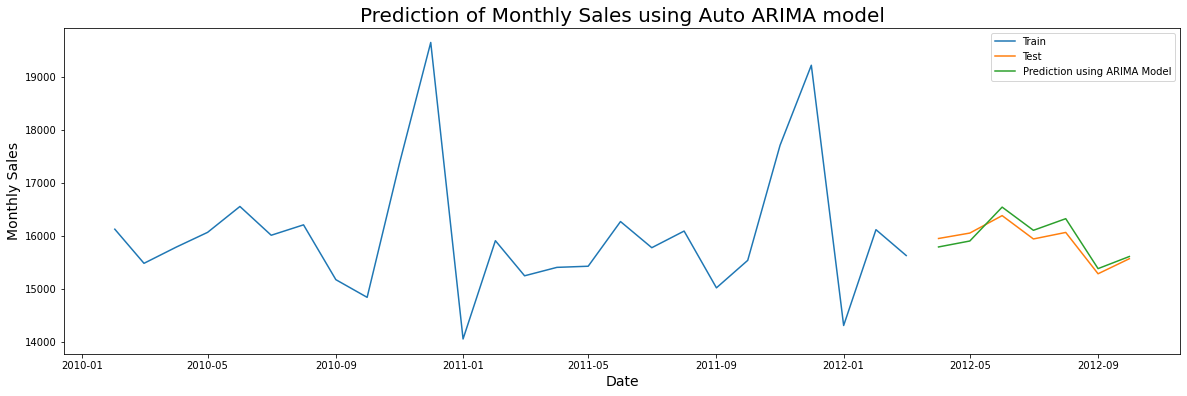

In [37]:
# Predicting the test values using predict function.
forecast = model_SARIMA_fit.forecast(steps=len(test))
forecast = forecast.to_frame()
plt.figure(figsize=(20,6))
plt.title('Prediction of Monthly Sales using Auto ARIMA model', fontsize=20)
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Prediction using ARIMA Model')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Monthly Sales', fontsize=14)
plt.show()

In [37]:
mse = mean_squared_error(test,forecast)
mse

25479.34212216421

In [38]:
model_SARIMA = SARIMAX(train,order=(0,1,0),seasonal_order=(1,1,1,12),exog = train_df[['Dept','MarkDown3']])
model_SARIMA_fit = model_SARIMA.fit()
model_SARIMA_fit.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.69320D+00    |proj g|=  2.34942D-01

At iterate    5    f=  3.68540D+00    |proj g|=  1.98571D-03

At iterate   10    f=  3.68525D+00    |proj g|=  6.43999D-02

At iterate   15    f=  3.68418D+00    |proj g|=  1.13261D-02

At iterate   20    f=  3.68323D+00    |proj g|=  5.99820D-03

At iterate   25    f=  3.68283D+00    |proj g|=  4.27634D-03

At iterate   30    f=  3.68258D+00    |proj g|=  1.05952D-04

At iterate   35    f=  3.68257D+00    |proj g|=  1.60124D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                        Monthly_Sales   No. Observations:                   26
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                 -95.747
Date:                              Mon, 21 Mar 2022   AIC                            201.494
Time:                                      00:53:49   BIC                            204.318
Sample:                                  02-01-2010   HQIC                           200.913
                                       - 03-01-2012                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Dept        -432.3524    612.413     -0.706      0.480   -1632.660     767.955
MarkDown3      0.0124      0.016      0.764      0.445      -0.019       0.044
ar.S.L12       0.8360      0.587      1.423      0.155      -0.315       1.987
ma.S.L12      -0.9802      0.724     -1.355      0.176      -2.398       0.438
sigma2      1.389e+05      0.022   6.37e+06      0.000    1.39e+05    1.39e+05
===================================================================================
Ljung-Box (L1) (Q):                   2.32   Jarque-Bera (JB):                 1.05
Prob(Q):                              0.13   Prob(JB):                         0.59
Heteroskedasticity (H):               1.77   Skew:                             0.68
Prob(H) (two-sided):                  0.60   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.93e+24. Standard errors may be unstable.
"""

In [39]:
sms.stats.acorr_ljungbox(model_SARIMA_fit.resid, lags=[12], return_df=True)

,lb_stat,lb_pvalue
12,8.448766,0.749152


In [40]:
forecast = model_SARIMA_fit.forecast(steps=len(test),exog=test_df[['Dept','MarkDown3']])

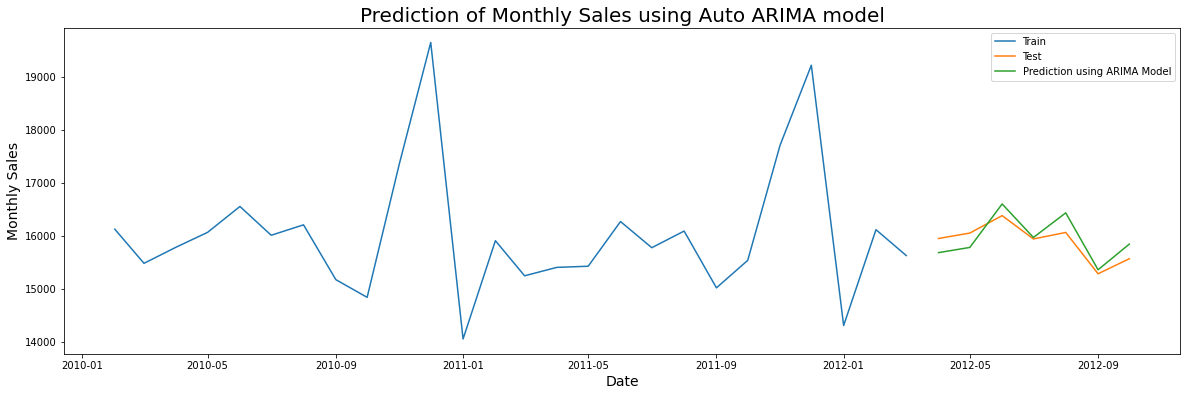

In [41]:
# Predicting the test values using predict function.
forecast = forecast.to_frame()
plt.figure(figsize=(20,6))
plt.title('Prediction of Monthly Sales using Auto ARIMA model', fontsize=20)
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Prediction using ARIMA Model')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Monthly Sales', fontsize=14)
plt.show()

In [42]:
mse = mean_squared_error(test,forecast)
mse

58755.38975635078

## FB Prophet

In [43]:
train = train.to_frame()
train.reset_index(drop=False,inplace=True)
train.rename(columns={'Date':'ds', 'Monthly_Sales':'y'}, inplace = True)

In [ ]:
m = Prophet(seasonality_mode = 'additive')
m.fit(train)  # df is a pandas.DataFrame with 'y' and 'ds' columns

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = m.make_future_dataframe(periods=7, freq='MS')
forecast = m.predict(future)
forecast_pred = forecast.tail(7)[['ds','yhat']]
forecast_pred.set_index('ds', inplace=True)
forecast_pred = forecast_pred['yhat']

In [ ]:
m.plot(forecast)

In [ ]:
# Predicting the test values using predict function.
train = train_df['Monthly_Sales']
forecast_pred = forecast_pred.to_frame()
plt.figure(figsize=(20,6))
plt.title('Prediction of Monthly Sales using FB Prophet', fontsize=20)
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast_pred, label='Prediction using FB Prophet')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Monthly Sales', fontsize=14)
plt.show()

In [ ]:
mse = mean_squared_error(test,forecast_pred)
mse